In [28]:
#Reference: https://www.kaggle.com/code/nadergo/conditional-vae-on-faces/notebook

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [30]:
# Load dataset: aligned cropped images from: https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html, saved to own drive

In [31]:
from PIL import Image
import glob
image_list = []
for filename in glob.glob("/content/drive/MyDrive/Colab Notebooks/AdvML-Spring'23/792-HW3/img_align_celeba/*.jpg"): 
    im=Image.open(filename)
    image_list.append(im)

In [32]:
len(image_list)

14570

In [33]:
#splitting into test and train data with 80-20 ratio
train_images=image_list[0:11656]
test_images=image_list[11656:14570]

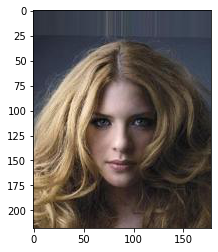

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# Let's see one of the train images from the dataset
plt.imshow(train_images[25])
plt.show()

In [36]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

import torch.optim as  optim 
if torch.cuda.is_available():  
  dev = "cuda:0" 
  print("gpu up")
else:  
  dev = "cpu"  
device = torch.device(dev)

In [39]:
# converting the txt file to csv file for easier data analysis and using as a dataframe

In [40]:
read_file = pd.read_csv (r"/content/drive/MyDrive/Colab Notebooks/AdvML-Spring'23/792-HW3/list_attr_celeba.txt")
read_file.to_csv (r"/content/drive/MyDrive/list_attr_celeba 2.csv", index=None)

In [49]:
# storing the labels for the images from the attributes file as a dataframe
df = pd.read_csv("list_attr_celeba 2.csv")
df.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [42]:
# defining encoder and decoder based on the instructions listed under Task-1

In [43]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        # channels_in, channels_out, kernel_size, stride, padding ->
        self.conv1 = nn.Conv2d(4, 32, 3, 2, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 2, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 2, 1)
        self.conv4 = nn.Conv2d(128, 256, 3, 2, 1)
        self.conv5 = nn.Conv2d(256, 512, 3, 2, 1)
        self.fc_mu = nn.Linear(512 * 2 * 2, 128)
        self.fc_logvar = nn.Linear(512 * 2 * 2, 128)

    def forward(self,x):
        x = nn.LeakyReLU(0.2)(self.conv1(x))
        x = nn.LeakyReLU(0.2)(self.conv2(x))
        x = nn.LeakyReLU(0.2)(self.conv3(x))
        x = nn.LeakyReLU(0.2)(self.conv4(x))
        x = nn.LeakyReLU(0.2)(self.conv5(x))
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar
        # return out.view(out.shape[0],-1)

In [44]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.fc = nn.Linear(128 + 40, 512 * 2 * 2)
        # channels_in, channels_out, kernel_size, stride, padding ->
        self.transconv1 = nn.ConvTranspose2d(512, 256, 3, 2, 1)
        self.transconv2 = nn.ConvTranspose2d(256, 128, 3, 4, 2)
        self.transconv3 = nn.ConvTranspose2d(128, 64, 3, 2, 1)
        self.transconv4 = nn.ConvTranspose2d(64, 32, 3, 2, 1)
        self.transconv5 = nn.ConvTranspose2d(32, 32, 3, 2, 1)
        self.transconv6 = nn.Conv2d(32, 4, 3, 1, 1)
        
    def forward(self,x):
        z = torch.cat([z],dim=1)
        out= self.transconv1(z.view(z.shape[0],z.shape[1],1,1))
        out = F.relu(out)
        out= self.transconv2(out)
        out = F.relu(out)
        out= self.transconv3(out)
        out = F.relu(out)
        out= self.transconv4(out)
        out = F.relu(out)
        out= self.transconv5(out)
        out = F.relu(out)
        out= self.transconv6(out)
        out = F.relu(out)
        return out

In [45]:
class CVAE(nn.Module):
    def __init__(self,encoder,decoder):
        super(CVAE,self).__init__()
        self.encoder = encoder()
        self.decoder = decoder()
        
    def forward(self,x,attrs):
        h = self.encoder(x)
        
        mu = h[:,:64]
        logvar = h[:,64:]
        s= torch.exp(logvar)  #reparameterization step
        eps = torch.randn_like(s)
        z = s*eps + mu 
        
        z= torch.cat([z,attrs],dim=1)
        out = self.decoder(z)
        return out,mu,logvar
        
vae = CVAE(Encoder,Decoder)
vae.to(device)


CVAE(
  (encoder): Encoder(
    (conv1): Conv2d(4, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (fc_mu): Linear(in_features=2048, out_features=128, bias=True)
    (fc_logvar): Linear(in_features=2048, out_features=128, bias=True)
  )
  (decoder): Decoder(
    (fc): Linear(in_features=168, out_features=2048, bias=True)
    (transconv1): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (transconv2): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(4, 4), padding=(2, 2))
    (transconv3): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (transconv4): ConvTranspose2d(64, 32, kernel_size=(3, 3),

In [50]:
def attributes(x):
    if x["Smiling"] == 1:
        return 0
    elif x["Mustache"] == 1:
        return 1
    elif x["Eyeglasses"] == 1:
        return 2
    else :
        return 3
    
df["Attributes"] = df.apply(attributes,axis=1)

In [51]:
# defining the attributes to be used for manipulation of the images in Task 2
df = df[["image_id","Attributes","Smiling",'Mustache',"Eyeglasses"]]

In [52]:
df.Smiling = df.Smiling.apply(lambda x: max(x,0)) 
df.Mustache = df.Mustache.apply(lambda x: max(x,0))
df.Eyeglasses = df.Eyeglasses.apply(lambda x: max(x,0))
df

,image_id,Attributes,Smiling,Mustache,Eyeglasses
0,000001.jpg,0,1,0,0
1,000002.jpg,0,1,0,0
2,000003.jpg,3,0,0,0
3,000004.jpg,3,0,0,0
4,000005.jpg,3,0,0,0
...,...,...,...,...,...
202594,202595.jpg,3,0,0,0
202595,202596.jpg,0,1,0,0
202596,202597.jpg,0,1,0,1
202597,202598.jpg,0,1,0,0


In [53]:
# Resize the images to shape [3,64,64] and normalize the pixels values to the range of [0,1].
faces =[]
# for i in df.iloc[:11656].image_id:
    # pic = Image.open("/content/drive/MyDrive/Colab Notebooks/AdvML-Spring'23/792-HW3/img_align_test/"+i)
for i in glob.glob("/content/drive/MyDrive/Colab Notebooks/AdvML-Spring'23/792-HW3/img_align_celeba/*.jpg")[0:11656]: 
    pic = Image.open(i)
    pic = pic.resize((64,64))
    pix = np.array(pic.getdata()).reshape(pic.size[0], pic.size[1], 3)
    pix = pix/255
    faces.append(np.moveaxis(pix,-1,0).tolist())
faces = np.array(faces)

In [54]:
len(faces)

11656

In [55]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        # channels_in ,  channels_out, kernel_size, stride , padding,
        self.conv1 = nn.Conv2d(3,64,3,1,1)
        self.conv2 = nn.Conv2d(64,64,3,1,1)
        self.conv3 = nn.Conv2d(64,64,4,2,1)
        self.conv4 = nn.Conv2d(64,128,4,2,1)
        self.maxp1 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.maxp2 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.maxp3 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.maxp4 = nn.MaxPool2d(kernel_size=2,stride=2)

    def forward(self,x):
        out = self.conv1(x)
        out = self.maxp1(out)
        out = F.relu(out) 
        out = self.conv2(out)
        out = self.maxp2(out)
        out = F.relu(out)
        out = self.conv3(out)
        out = self.maxp3(out)
        out = F.relu(out)
        out= self.conv4(out)
        out = self.maxp4(out)
        out = F.relu(out)
        return out.view(out.shape[0],-1)
    
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        
        self.transconv1 = nn.ConvTranspose2d(64+ 40,64,8,4,2)
        self.transconv2 = nn.ConvTranspose2d(64,64,8,4,2)
        self.transconv3 = nn.ConvTranspose2d(64,64,4,2,1)
        self.transconv4 = nn.ConvTranspose2d(64,3,4,2,1)
        
        self.attributeEmbedding = nn.Embedding(4,10)
        self.eyeglassesEmbedding = nn.Embedding(2,10)
        self.mustacheEmbedding = nn.Embedding(2,10)
        self.smilingEmbedding = nn.Embedding(2,10)

        
    def forward(self,x):
        z = x[:,:64]
        attribute = self.attributeEmbedding(x[:,64].long())
        smiling = self.smilingEmbedding(x[:,65].long())
        mustache = self.mustacheEmbedding(x[:,66].long())
        eyeglasses = self.eyeglassesEmbedding(x[:,67].long())
        # Concating the embeddings and the encoded image
        z = torch.cat([z,attribute,eyeglasses,mustache,smiling],dim=1)
        out= self.transconv1(z.view(z.shape[0],z.shape[1],1,1))
        out = F.relu(out)
        out= self.transconv2(out)
        out = F.relu(out)
        out= self.transconv3(out)
        out = F.relu(out)
        out= self.transconv4(out)
        out = F.relu(out)
        return out
        
class CVAE(nn.Module):
    def __init__(self,encoder,decoder):
        super(CVAE,self).__init__()
        self.encoder = encoder()
        self.decoder = decoder()
    def forward(self,x,attrs):
        h = self.encoder(x)
        mu = h[:,:64]
        logvar = h[:,64:]
        # this part is for the reparameterization trick
        s= torch.exp(logvar)
        eps = torch.randn_like(s)
        z = s*eps + mu 
        z= torch.cat([z,attrs],dim=1)
        out = self.decoder(z)
        return out,mu,logvar
        
vae = CVAE(Encoder,Decoder)
vae.to(device)

CVAE(
  (encoder): Encoder(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (maxp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (maxp2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (maxp3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (maxp4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Decoder(
    (transconv1): ConvTranspose2d(104, 64, kernel_size=(8, 8), stride=(4, 4), padding=(2, 2))
    (transconv2): ConvTranspose2d(64, 64, kernel_size=(8, 8), stride=(4, 4), padding=(2, 2))
    (transconv3): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)

In [125]:
def ceil(a,b):
    return -(-a//b)

def loss_function(recon_x,x,mu,logvar):
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    KLD /= x.shape[0] * 3 * 64 * 64
    recon_loss = F.mse_loss(recon_x,x)
    return recon_loss +  KLD

epochs = 10
batch_size= 10
optimizer = optim.Adagrad(vae.parameters(),lr = 0.001)
npData = df.iloc[:11656].to_numpy()

n_samples = len(npData)
better_batch_size = ceil(n_samples, ceil(n_samples, batch_size))
losstrack = []
for e in range(epochs):
    losses = []
    for i in range(ceil(n_samples, better_batch_size)):
        batch = npData[i * better_batch_size: (i+1) * better_batch_size]
        attrs = torch.Tensor(batch[:,1:].astype('float16')).to(device)
        
        imgs = faces[i * better_batch_size: (i+1) * better_batch_size]
        imgs = torch.Tensor(imgs.astype('float16')).to(device)
        vae.zero_grad()
        recon_imgs,mu,logvar = vae(imgs,attrs)
        err = loss_function(recon_imgs,imgs,mu,logvar)
        err.backward()
        optimizer.step()
        losses.append(err.item())
    losstrack.append(np.mean(losses))
    if e % 100 == 0: 
        torch.save(vae.state_dict(), "./cvae.pt")
        print("mean loss = ",np.mean(losses) )


mean loss =  0.13628602265595982


In [126]:
checkpoint = torch.load("cvae.pt")
vae.load_state_dict(checkpoint)

<All keys matched successfully>

In [127]:
def showImage(x):
    attrs = torch.Tensor(x)
    h = torch.cat((torch.randn(1,64),attrs),dim=1).to(device)
    img = vae.decoder(h)
    img = img.cpu().detach().numpy().reshape(3,64,64)
    img = np.moveaxis(img,0,-1)
    return img

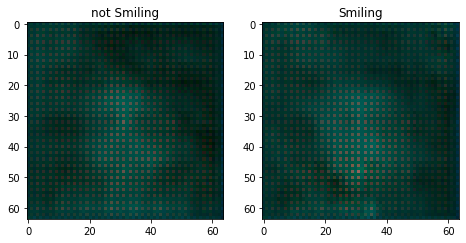

In [128]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(showImage([[2,0,0,1]]))
axarr[0].set_title("not Smiling")
axarr[1].imshow(showImage([[2,1,0,1]]))
axarr[1].set_title("Smiling")

f.subplots_adjust(hspace=0.3,left=2,right=3)

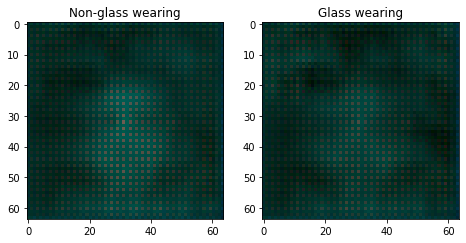

In [129]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(showImage([[2,0,1,0]]))
axarr[0].set_title("Non-glass wearing")
axarr[1].imshow(showImage([[2,0,1,1]]))
axarr[1].set_title("Glass wearing")
f.subplots_adjust(hspace=0.3,left=2,right=3)

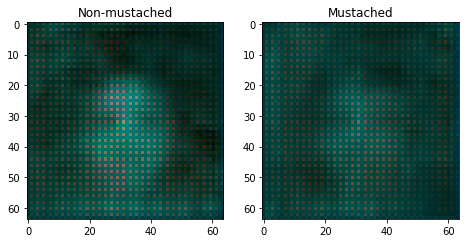

In [130]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(showImage([[2,0,0,0]]))
axarr[0].set_title("Non-mustached")
axarr[1].imshow(showImage([[2,1,1,0]]))
axarr[1].set_title("Mustached")
f.subplots_adjust(hspace=0.3,left=2,right=3)

In [ ]:
# We can see from the above images the evident change in attributes, although little blurred.
# An observation while training the model has been that increasing the size of dataset improving quality of the reproduced images.
# Changing the hyper-paramenters such as learning rate also have impacted the output of the model
# here, I have taken a smaller portion of the entire CelebA dataset images due to large amount to time needed to train the model, hence, the picture quality. 